# MSBC5180 HW4: Sentiment Classification 

### Solution by: Anne Pierce

In this assignment, you will classify the *sentiment* (positive, negative, or neutral) of hotel reviews posted on Yelp. See Chapter 8 of the textbook for more explanation of sentiment classification. The main goal of this assignment is to get practice with feature engineering, feature extraction, and feature selection.

## What to Hand In
You will turn in a completed notebook on Canvas as a ipynb file. Your submission should be contained in a single Jupyter notebook named `hw4-firtname-lastname.ipynb`, where `firstname` and `lastname` are replaced with your first and last names. This will include your code as well as figures and answers to questions. Please create headers for your cells that are labeled “Deliverable” followed by the problem number, so that your responses are easy to find.

## The Associated Quiz
You will complete the associated quiz for HW4 on Canvas. The quiz is name **"Quiz HW4 "**.

## Collaboration policies
You are allowed to work with up to 3 people besides yourself. You are still expected to write up your own solution. Each individual must turn in their own submission, and list your collaborators after your name.

## Asking for Help
You are encouraged to ask questions on the Zoom channel. Do not post anything that you are turning in. In this assignment, that would be any of the plots you need to hand in, or the parameter values. However, you can describe your results, like the number of iterations it took to converge, and general things you observe about the algorithms.
You may ask questions to help with debugging, but do not post your code in a way of giving away solution. You can share error messages and describe what you are trying to do with your code, but try not to write enough to “give away” the solution.

## Annotated data

The dataset contains 1,000 reviews of hotels downloaded from Yelp. Sentiment labels could be one of three classes (positive, negative, neutral). Each review is labeled as:

- **1:** The review expresses a *positive* opinion toward the hotel.
- **0:** The review expresses a mixed or neutral opinion toward the hotel.
- **-1:** The review expresses a *negative* opinion toward the hotel.

In this assignment, you will build classifiers to predict these three classes. The dataset has been prepared for you. A random subset (approximately 10% of the reviews) was selected as test data, while the rest will be used for training. Run the code below to download and extract the data.

In [21]:
import pandas as pd
import numpy as np

df = pd.read_csv('yelp_hotels1000.csv', 
                 header=None, encoding='ISO-8859-1')

df_train = df.loc[df[1] == 'train']
df_test = df.loc[df[1] == 'test']

Y_train = df_train.iloc[0:, 2].values
text_train = df_train.iloc[0:, 3].values

Y_test = df_test.iloc[0:, 2].values
text_test = df_test.iloc[0:, 3].values

## Setting up the classifier

### Tokenization and feature extraction

The first step is to convert the raw text into feature vectors. In Ch. 8 of the book, and in HW2, the class [`CountVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) is presented as a way to convert text strings into `sklearn` feature vectors. This class can automatically perform tokenization (doing preprocessing steps we talked about in class, including lowercasing and stripping punctuation). However, for this assignment, we aren't going to use `CountVectorizer`, though it is useful to know about. We will instead write our own code to do tokenization and feature extraction. This will allow us to modify the features, which you will need to do later, plus it will let you see how feature extraction is done.

The code below defines our feature extraction function, `features`. It takes a text string and it outputs a Python dictionary where the keys are the feature names and the values are the feature values. This is a _sparse_ representation, meaning it only outputs features with nonzero value.

By default, the features extracted by this function are n-gram counts. The keyword argument `ngram_range` specifies the length of n-grams to extract. This argument should be a pair of integers, where the first integer is the lower end of the length to be extracted and the second integer is the upper end. For example, `ngram_range=(1,3)` will extract 1-grams, 2-grams, and 3-grams, while `ngram_range=(2,2)` will extract only 2-grams.

The function performs two initial preprocessing steps: making the text lowercase (so different capitalizations of words will map to the same feature), and removing consecutive characters that are repeated more than twice (e.g., "woooow" and "wooooooooow" will both map to simply "woow" rather than being counted as separate words).

The function tokenizes words as follows. First, non-alphanumeric characters are replaced with whitespace, then strings separated by whitespace are treated as tokens. Python's `split` function converts a string into a list of tokens that were separated by whitespace. The list of tokens is passed to the `ngrams` function, defined below, which returns a list of all n-grams of length `n` contained in the list. Finally, the function also pulls out tokens containing anything _but_ alphanumeric characters. This will capture punctuation marks and emojis, which may also be useful for classification. These are treated as unigram features rather than longer sequences.

For now, simply run the code below. However, you'll need to modify this code later, so you need to understand what it is doing.

In [54]:
import re
from collections import Counter

def ngrams(tokens, n):
    output = []
    for i in range(n-1, len(tokens)):
        ngram = ' '.join(tokens[i-n+1:i+1])
        output.append(ngram)
    return output

def features(text, ngram_range=(1,1)):
    text = text.lower()      # make the string lowercase
    text = re.sub(r'(.)\1+', r'\1\1', text)     # remove consecutive characters that are repeated more than twice
    
    features_in_text = []   # running list of all features in this instance (can be repeated)
    
    # treat alphanumeric characters as word tokens (removing anything else),
    # and extract all n-grams of length n specified by ngram_range
    
    text_alphanum = re.sub('[^a-z0-9]', ' ', text)
    for n in range(ngram_range[0], ngram_range[1]+1):
        features_in_text += ngrams(text_alphanum.split(), n)
    
    # now treat punctuation as word tokens, and get their counts (only unigrams)
    
    text_punc = re.sub('[a-z0-9]', ' ', text)
    features_in_text += ngrams(text_punc.split(), 1)
    
    # 'Counter' converts a list into a dictionary whose keys are the list elements 
    #  and the values are the number of times each element appeared in the list
    
    return Counter(features_in_text)


To get a better understanding of what the `features` function is returning, see what happens on the example text when you run the code below. The `ngram_range` is set to `(1,2)` which means it will extract both 1-grams and 2-grams. You should notice that it extracts all words (separated by punctuation) and two-word phrases, with counts based on how often they appear (e.g., "`a sentence`" is a 2-gram that appears twice). Also note that punctuation is also counted (but only as 1-grams, not 2-grams), and notice that "`!!`" has a count of 2 because "!!!" was rewritten as "!!".

You may find it helpful to change the text and/or the n-gram range to see what features are extracted.

In [55]:
text = "This is an example of a sentence to tokenize!! Actually, it's more than a sentence, it's two sentences!!!"

print(features(text, ngram_range=(1,2)))

this is an example of a sentence to tokenize   actually  it s more than a sentence  it s two sentences  
Counter({'a': 2, 'sentence': 2, 'it': 2, 's': 2, 'a sentence': 2, 'it s': 2, '!!': 2, ',': 2, "'": 2, 'this': 1, 'is': 1, 'an': 1, 'example': 1, 'of': 1, 'to': 1, 'tokenize': 1, 'actually': 1, 'more': 1, 'than': 1, 'two': 1, 'sentences': 1, 'this is': 1, 'is an': 1, 'an example': 1, 'example of': 1, 'of a': 1, 'sentence to': 1, 'to tokenize': 1, 'tokenize actually': 1, 'actually it': 1, 's more': 1, 'more than': 1, 'than a': 1, 'sentence it': 1, 's two': 1, 'two sentences': 1})


Finally, we need to extract features from all of the training instances and convert them into a feature vector representation to be used by `sklearn`. The code below takes the output of the `features` function (with only 1-grams for this example, though you will change this later), then maps all the feature strings into integers, then defines `X_train` as a sparse array that encodes the values of each feature in each instance. Like in HW2, the [`DictVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) is used to do this conversion. 

In [24]:
from sklearn.feature_extraction import DictVectorizer

vect = DictVectorizer()
X_train = vect.fit_transform(features(d, ngram_range=(1,3)) for d in text_train)

### Classifier and hyperparameter tuning

In this assignment, we will use multinomial logistic regression as our classifier. Recall that logistic regression outputs probabilities, and the multinomial version can handle more than two classes. Mulinomial logistic regression is also called a "maximum entropy" or "MaxEnt" classifier.

We will use `sklearn`'s [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) class, setting the `multi_class` argument to `'multinomial'` which tells it to use the multinomial version (otherwise it defaults to binary logistic regression with a one-vs-rest scheme for multiclass data).

The `LogisticRegression` class uses the argument `C` to denote the regularization strength (same as in the `SVC` class you used in HW3). It is important to adjust this hyperparameter to get good performance. We will tune this hyperparameter each time we build a classifier, using cross-validation for optimizing `C`. 

`sklearn` has a class, [`GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) for tuning a classifier with cross-validation. When you construct a `GridSearchCV` object, you supply the set of parameters and their possible values that you would like to adjust. During training, it will perform cross-validation with every combination of parameter values, then train a final classifier using the best-performing settings. In the code, only a small number of values are listed, because it would be too slow to try many combinations.

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score

# this defines the classifier we will use -- don't change this variable

base_classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs', tol=1e-2, max_iter=500, random_state=123)

# these are the C values we will compare -- don't change this variable

params = [{'C': [0.01, 0.1, 1.0]}]

# this performs 3-fold cross-validation with the above classifier and parameter options

gs_classifier = GridSearchCV(base_classifier, params, cv=3)
gs_classifier.fit(X_train, Y_train)

print(gs_classifier.get_params())

print("Best parameter settings:", gs_classifier.best_params_)
print("Validation accuracy: %0.6f" % gs_classifier.best_score_)

{'cv': 3, 'error_score': nan, 'estimator__C': 1.0, 'estimator__class_weight': None, 'estimator__dual': False, 'estimator__fit_intercept': True, 'estimator__intercept_scaling': 1, 'estimator__l1_ratio': None, 'estimator__max_iter': 500, 'estimator__multi_class': 'multinomial', 'estimator__n_jobs': None, 'estimator__penalty': 'l2', 'estimator__random_state': 123, 'estimator__solver': 'lbfgs', 'estimator__tol': 0.01, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': LogisticRegression(max_iter=500, multi_class='multinomial', random_state=123,
                   tol=0.01), 'n_jobs': None, 'param_grid': [{'C': [0.01, 0.1, 1.0]}], 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}
Best parameter settings: {'C': 1.0}
Validation accuracy: 0.730317


In the code above, calling `gs_classifier.fit` will perform cross-validation for all parameter settings. Once it finishes, then `gs_classifier` can be used as any other classifier object, so you can call the `predict` or `predict_proba` functions to make classifications, just as you did in HW3. As you can see in the code above, the object also contains variables that will give you the optimal parameters and cross-validation accuracy.

Throughout this assignment, anytime you are asked to train a classifier, you should do so by calling `GridSearchCV(base_classifier, params, cv=3)` rather than directly calling the `LogisticRegression` class. Whenever you are asked for the cross-validation accuracy, this is given by the `best_score_` variable that you see above.

## Problem 1: Feature Choice and Selection

We will begin by experimenting with different feature sets, where we modify the feature set in two ways. First, we will experiment with different sizes of n-grams. Second, we will experiment with automated feature selection.

### N-gram size

As you saw above, the `features` function takes a keyword argument, `ngram_range`, that let's you specify the sizes of n-grams to extract. Experiment with six different ranges of n-gram sizes: (1,1), (2,2), (3,3), (1,2), (1,3), (2,3)

For each n-gram range, you'll need to re-extract and vectorize the features (calling the `features` and `vect.fit_transform` functions, as done above). For each setting, calculate the cross-validation accuracy after using `GridSearchCV` to find the best $C$ value.

#### Deliverable 1.1: Fill in the table below with the cross-validation accuracy when using each range of n-grams.

| N-grams | Validation accuracy |
|---------|---------------------|
| (1,1)   |   0.753913          |
| (2,2)   |   0.695502          |
| (3,3)   |   0.619104          |
| (1,2)   |   0.742667          |
| (1,3)   |   0.730317          |
| (2,3)   |   0.677534          |



In [13]:
# code for 1.1 here
ngram_sizes = [(1,1), (2,2), (3,3), (1,2), (1,3), (2,3)]
for i in ngram_sizes:
    X_train = vect.fit_transform(features(d, ngram_range=i) for d in text_train)
    params = [{'C': [0.01, 0.1, 1.0]}]

    # this performs 3-fold cross-validation with the above classifier and parameter options

    gs_classifier = GridSearchCV(base_classifier, params, cv=3)
    gs_classifier.fit(X_train, Y_train)

    #print(gs_classifier.get_params())
    print("This is n-gram size:", i)
    print("Best parameter settings:", gs_classifier.best_params_)
    print("Validation accuracy: %0.6f" % gs_classifier.best_score_)

This is n-gram size: (1, 1)
Best parameter settings: {'C': 0.1}
Validation accuracy: 0.753913
This is n-gram size: (2, 2)
Best parameter settings: {'C': 1.0}
Validation accuracy: 0.695502
This is n-gram size: (3, 3)
Best parameter settings: {'C': 0.1}
Validation accuracy: 0.619104
This is n-gram size: (1, 2)
Best parameter settings: {'C': 1.0}
Validation accuracy: 0.742667
This is n-gram size: (1, 3)
Best parameter settings: {'C': 1.0}
Validation accuracy: 0.730317
This is n-gram size: (2, 3)
Best parameter settings: {'C': 1.0}
Validation accuracy: 0.677534


#### Deliverable 1.2: Describe what you observe with different length n-grams. When using only one type of n-gram (1, 2, or 3), how does the length affect accuracy? How does using only one size of n-gram (1, 2, or 3) compare to using a range of different sizes (1-2, 1-3, or 2-3)?

[Although this is not the case for n-gram (1,1), the general pattern is that when you use a range of n-gram sizes, you get a better validation accuracy. Additionally, Wwen using only one type of n-gram (1,1) vs (2,2), vs (3,3), the accuracy decreases as the length increases.

### Feature selection

Selecting a subset of features can improve classifier efficiency and potentially guard against overfitting. However, it can also hurt performance if too many features are removed. We will now experiment with different levels of feature selection.

We will use the [`SelectPercentile`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectPercentile.html) class, which can be used to select features that are within a specified percentile according to a scoring function that ranks the quality of the features. The code below instantiates a `SelectPercentile` object using the [`chi2`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html) function, which performs a chi-squared test for measuring the significance of features. The `percentile` argument specifies the percentile of features that are selected after ranking by their chi-squared statistic. If `percentile=1`, only the top 1% of features will be selected. If `percentile=100`, all features will be selected.

Once you've created a `SelectPercentile` object, its `fit` function can be called to calculate the significance of the features, and its `transform` function will modify the feature vectors to choose only the selected features. The `fit_transform` function performs both of these steps, which is what you see below.

Experiment with different feature selection percentiles to see how the accuracy is affected by different settings.

#### Deliverable 1.3: Calculate the cross-validation accuracy at different values of `percentile`, when the percentile is each of $[1, 2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]$. Create a plot where the percentile is on the x-axis and the accuracy is on the y-axis. Do this for three different settings with the base classifer defined above, using n-gram ranges of (1,1), (2,2), and (1,3). You can either create three different figures for these three n-gram ranges, or create one figure with three lines (clearly labeled).

[I created one plot with all three lines labeled.]




In [25]:
from sklearn.feature_selection import SelectPercentile, chi2

# example: feature selection at the 60th percentile.
# Note the renaming of the feature vectors to X_train_selected

selection = SelectPercentile(percentile=60, score_func=chi2)
X_train_selected = selection.fit_transform(X_train, Y_train)


In [29]:
# code for 1.3 here

percentile_values = [1,2,5,10,20,30,40,50,60,70,80,90,100]
accuracy_vals_one = []
for i in percentile_values:
    X_train = vect.fit_transform(features(d, ngram_range=(1,1)) for d in text_train)
    gs_classifier = GridSearchCV(base_classifier, params, cv=3)
    
    selection = SelectPercentile(percentile=i, score_func=chi2)
    X_train_selected = selection.fit_transform(X_train, Y_train)
    params = [{'C': [0.01, 0.1, 1.0]}]

    gs_classifier = GridSearchCV(base_classifier, params, cv=3)
    gs_classifier.fit(X_train_selected, Y_train)
    accuracy_vals_one.append(gs_classifier.best_score_)
print(accuracy_vals_one)
 
accuracy_vals_two = []
for i in percentile_values:
    X_train = vect.fit_transform(features(d, ngram_range=(2,2)) for d in text_train)
    gs_classifier = GridSearchCV(base_classifier, params, cv=3)
    
    selection = SelectPercentile(percentile=i, score_func=chi2)
    X_train_selected = selection.fit_transform(X_train, Y_train)
    params = [{'C': [0.01, 0.1, 1.0]}]

    gs_classifier = GridSearchCV(base_classifier, params, cv=3)
    gs_classifier.fit(X_train_selected, Y_train)
    accuracy_vals_two.append(gs_classifier.best_score_)
print(accuracy_vals_two)
 
accuracy_vals_three = []
for i in percentile_values:
    X_train = vect.fit_transform(features(d, ngram_range=(1,3)) for d in text_train)
    gs_classifier = GridSearchCV(base_classifier, params, cv=3)
    
    selection = SelectPercentile(percentile=i, score_func=chi2)
    X_train_selected = selection.fit_transform(X_train, Y_train)
    params = [{'C': [0.01, 0.1, 1.0]}]

    gs_classifier = GridSearchCV(base_classifier, params, cv=3)
    gs_classifier.fit(X_train_selected, Y_train)
    accuracy_vals_three.append(gs_classifier.best_score_)
print(accuracy_vals_three)

[0.7370286953620288, 0.7449305365972032, 0.7629030545697212, 0.7673961840628508, 0.7651477234810568, 0.764014014014014, 0.7595284678618013, 0.75503913003913, 0.7516683350016683, 0.752802044468711, 0.7516759183425851, 0.7527982527982529, 0.753913003913004]
[0.7617655534322202, 0.7617617617617617, 0.7471714138380805, 0.7404336154336154, 0.7527906694573362, 0.7179869263202597, 0.7067408317408317, 0.7022514939181606, 0.7033738283738283, 0.7067408317408317, 0.7089855006521674, 0.7146009646009647, 0.6955023205023205]
[0.7730154396821064, 0.7819979069979069, 0.7775085691752358, 0.7707821457821457, 0.7628992628992629, 0.7460414960414962, 0.739303697637031, 0.7314435647768981, 0.7303136469803135, 0.7426744926744927, 0.7437930354597021, 0.7449229532562865, 0.730317438650772]


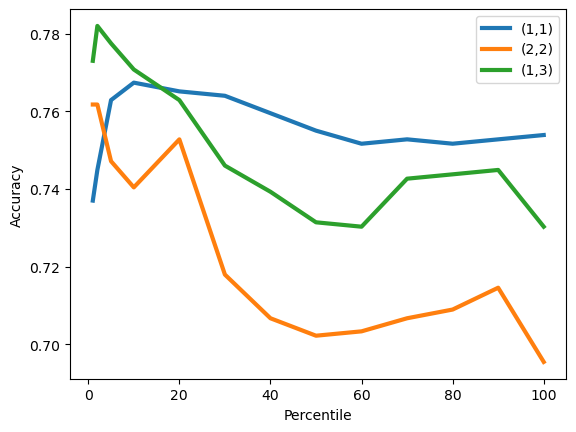

In [30]:
import matplotlib.pyplot as plt

plt.plot(percentile_values, accuracy_vals_one, label="(1,1)", linewidth=3)
plt.plot(percentile_values, accuracy_vals_two, label="(2,2)", linewidth=3)
plt.plot(percentile_values, accuracy_vals_three, label="(1,3)", linewidth=3)
plt.xlabel("Percentile")
plt.ylabel("Accuracy")
plt.legend()

#### Deliverable 1.4: Describe what you observe in the 1.3 plots. Comment on any general patterns that you see across all of the plots, and explain why you think this behavior happens. Additionally, comment on any differences in the patterns between the three different classifiers. If there are any differences, what do you think explains the differences?

[Generally, the n-gram lengths perform worse with increasing precentile of features. This is likely because the quality of the features included isnt as good. Thus, with only the highest quality features included, they generally perform better. This pattern looks a little different with (1,1) ngram. In this case the most selective percentile doesnt perform as well. This is likely because you are only working with words of length one. Thus, by only using a select number of features, this may be too limited information to perfrom optimally.]

## Problem 2: Feature Engineering 

### Problem 2 of the Coding Part is significantly more demanding this time. However, it is only worth 2 points out of the total 26 points. You might consider the return of the time and effort you need to put in when you work on the coding part.

### Choosing final hyperparameters

Above, you experimented with various ranges of n-grams and feature selection percentiles. For the remainder of this assignment, you should stick with one setting of n-gram range and percentile.

In the code below, the variables `ngr` and `per` define the n-gram range and percentile that you will use in the remaining experience. Currently, `ngr` is set to $(1,3)$ and `per` is set to $100$, but you should modify these values as needed and set them to whatever values gave you the best validation accuracy in your experiments in Problem 1.

In [31]:
ngr = (1,3)
per = 2

Since we are no longer tuning the hyperparameters, now is a reasonable time to also look at the test data. The code below calculates both the cross-validation as well as the accuracy on the test data using the best classifier from cross-validation, using the randomly chosen n-gram and percentile settings. 

You don't need to do anything in this section except understand and run the code in the cell below.

In [32]:
X_train_final = vect.fit_transform(features(d, ngram_range=ngr) for d in text_train)
X_test_final = vect.transform(features(d, ngram_range=ngr) for d in text_test)

selection = SelectPercentile(percentile=per, score_func=chi2)
X_train_final = selection.fit_transform(X_train_final, Y_train)
X_test_final = selection.transform(X_test_final)

gs_classifier = GridSearchCV(base_classifier, params, cv=5)
gs_classifier.fit(X_train_final, Y_train)

print("Validation accuracy: %0.6f" % gs_classifier.best_score_)
print("Test accuracy: %0.6f" % accuracy_score(Y_test, gs_classifier.predict(X_test_final)))

Validation accuracy: 0.797753
Test accuracy: 0.718182


### Creating new features

How do you add new features? You will need to create a new feature extraction function. Start by copying the definition of the `features` function at the start of this notebook and renaming it. Keep everything from the original function, but write additional code that appends your new features to the `features_in_text` array. You can create any additional helper functions as needed.

The description of each feature type is below. Be sure to read the instructions carefully.

- **Skip-grams:** A type of feature that is related to an n-gram is a _skip-gram_. Skip-grams can be defined in different ways, but the definition you will use here is a sequence of word tokens where only the first and last word are specified, while any word token in between is replaced with a general placeholder symbol (usually an asterisk, $*$). For example, the string "the water is cold" contains two length-3 skip-grams ("`the * is`" and "`water * cold`") and one length-4 skip-gram ("`the * * cold`"). The purpose of skip-grams is to capture longer sequences while being general enough to match more instances than with longer n-grams. To implement a skip-gram of length $k$, you can simply extract $k$-grams (i.e., n-grams of length $k$) and replace the inner tokens with asterisks. Like with the n-gram features, the values of the skip-gram features should be their counts. For this assignment, you should extract skip-grams of both length 3 and length 4.
- **Word pairs:** It may be helpful to encode combinations of words that appear in a document, regardless of whether they appear in a particular sequence. One type of feature is to indicate if two words are both present in a text (like doing an *AND* operation on the presense of the two unigrams). For example, the string "the water is cold" contains 6 distinct word pairs ("`(the,water)`", "`(the,is)`", "`(the,cold)`", "`(water,is)`", "`(water,cold)`", "`(is,cold)`"). For full credit, your code should not include pairs that are permutations of each other $-$ for example, include `(water,cold)` or `(cold,water)` but not both. An easy way to do this is to sort the words in alphabetical order within pairs. For this feature, simply use the value $1$ if the pair is present in a text and $0$ otherwise (that is, binary values rather than using full counts).
- **Sentiment dictionary:** One might also take advantage of external resources others have created for sentiment analysis. For this type of feature, we will use a sentiment *lexicon* created by researcher [Bing Liu](https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html), which is a list of words that have a tendency to show positive sentiment and a list of words with negative sentiment. The lexicon contains thousands of words; the words are already loaded for you in the code cell below. For this feature, you should extract n-grams (using whatever n-gram range was randomly selected above) where any word that appears in the positive dictionary is replaced with the capitalized string "`POS`" and any word in the negative dictionary is replaced with the string "`NEG`". For full credit, you should extract all original n-grams (before doing dictionary replacement) as well as n-grams with the replaced sentiment strings, but without double-counting the original n-grams. For example, the word "cold" is in the negative dictionary, so the string "the water is cold" should have five unigrams all with value $1$ ("`the`", "`water`", "`is`", "`cold`", "`NEG`"), and four bigrams with value with $1$ ("`the water`", "`water is`", "`is cold`", "`is NEG`").

After writing your new function, you should test the function on a few example strings to see if it is extracting features in the way you expect.

#### Deliverable 2.1: Say which feature(s) you were able to implemented.  If you were unable to fully implement them all, describe what you attempted to do, and any challenges you ran into. 

[I was able to implement all 3: skip-grams, word pairs, and sentiment dictionary. No challenges encountered.]

#### Deliverable 2.2: Calculate the cross-validation accuracy and test accuracy using your new feature set. Compare the new accuracies with the accuracies in the code cell above, before you changed the features. Your new features may help, hurt, or make no change to the accuracy. In any case, give a possible explanation for why it affected (or didn't affect) the accuracy.

[All my code is below. Using skip grams improved the accuracy with ngram (1,3), likely because you have an increased number of occurances now that have the same semantic meaning (pos, neg, neut). You have an increased number of occurances because you need fewer words to match because the words in the middle are replaced with an "*". However, the sentiment of the word liekly stays the same. For example if you were to have "The room was cold" and "The shower was cold", both of these are negative. With the previously used feature these would be classified as separate phrases but now with the skip grams, they would be classified as the same phrase. It seems that using word pairs slightly worsens performance. Using the sentiment dictionary slightly increases accuracy. This makes sense because you are using a sentiment bank to help find words.]

In [125]:
## If you are using the third feature type (sentiment dictionary),
## run this block of code.

# (original source: http://www.cs.uic.edu/~liub/FBS/opinion-lexicon-English.rar )

sentiment_df = pd.read_csv('sentiment-words.csv', header=None, encoding='ISO-8859-1')

# The two variables, positive_words and negative_words, are sets that contain the positive/negative words

positive_words = sentiment_df.loc[sentiment_df[0] == 'positive']
positive_words = set(positive_words.iloc[0:, 1].values)

negative_words = sentiment_df.loc[sentiment_df[0] == 'negative']
negative_words = set(negative_words.iloc[0:, 1].values)

In [144]:
print(positive_words)

{'comely', 'harmoniously', 'manageable', 'rejoicingly', 'exalted', 'cheery', 'fascinating', 'fervently', 'wholeheartedly', 'sweetly', 'guarantee', 'endorsing', 'electrify', 'pleasing', 'master', 'improve', 'effusively', 'heaven', 'tremendously', 'winnable', 'illuminate', 'admiringly', 'accommodative', 'intriguingly', 'stabilize', 'exuberantly', 'energy-saving', 'cleared', 'quieter', 'optimism', 'relaxed', 'clever', 'intriguing', 'mercy', 'bullish', 'hopeful', 'celebrate', 'luck', 'piety', 'realizable', 'nicest', 'affability', 'lucidly', 'efficient', 'enthrall', 'spacious', 'well-intentioned', 'stainless', 'amazed', 'loving', 'lead', 'hail', 'valor', 'dote', 'luckiness', 'successful', 'jollify', 'hooray', 'idolized', 'rapport', 'easygoing', 'keen', 'stirringly', 'supremely', 'reclaim', 'excellency', 'humble', 'revive', 'marveled', 'wonder', 'humour', 'gleefully', 'satisfies', 'flawless', 'adroit', 'prudence', 'navigable', 'foresight', 'well-connected', 'breeze', 'heavenly', 'excels', 'r

In [68]:
# skip grams
def features_skip(text, ngram_range=(1,3)):
    text = text.lower()      # make the string lowercase
    text = re.sub(r'(.)\1+', r'\1\1', text)     # remove consecutive characters that are repeated more than twice
    
    features_in_text = []   # running list of all features in this instance (can be repeated)
    
    # treat alphanumeric characters as word tokens (removing anything else),
    # and extract all n-grams of length n specified by ngram_range
    
    text_alphanum = re.sub('[^a-z0-9]', ' ', text)
    for n in range(ngram_range[0], ngram_range[1]+1):
        features_in_text += ngrams(text_alphanum.split(), n)
    
    # replace word ngrams with asterisks
    for index, ngram in enumerate(features_in_text):
        word_vec = ngram.split()
        word_vec_len = len(word_vec)
        if word_vec_len > 2:
            asterisk_count = word_vec_len - 2
            features_in_text[index] = " ".join([word_vec[0]] + ["*"]*asterisk_count + [word_vec[-1]])
    
    # now treat punctuation as word tokens, and get their counts (only unigrams)
    
    text_punc = re.sub('[a-z0-9]', ' ', text)
    features_in_text += ngrams(text_punc.split(), 1)
    
    # 'Counter' converts a list into a dictionary whose keys are the list elements 
    #  and the values are the number of times each element appeared in the list
    return Counter(features_in_text)

In [71]:
text = "This is an example of a sentence to tokenize!! Actually, it's more than a sentence, it's two sentences!!!"

print(features_skip(text, ngram_range=(1,3)))

Counter({'a': 2, 'sentence': 2, 'it': 2, 's': 2, 'a sentence': 2, 'it s': 2, '!!': 2, ',': 2, "'": 2, 'this': 1, 'is': 1, 'an': 1, 'example': 1, 'of': 1, 'to': 1, 'tokenize': 1, 'actually': 1, 'more': 1, 'than': 1, 'two': 1, 'sentences': 1, 'this is': 1, 'is an': 1, 'an example': 1, 'example of': 1, 'of a': 1, 'sentence to': 1, 'to tokenize': 1, 'tokenize actually': 1, 'actually it': 1, 's more': 1, 'more than': 1, 'than a': 1, 'sentence it': 1, 's two': 1, 'two sentences': 1, 'this * an': 1, 'is * example': 1, 'an * of': 1, 'example * a': 1, 'of * sentence': 1, 'a * to': 1, 'sentence * tokenize': 1, 'to * actually': 1, 'tokenize * it': 1, 'actually * s': 1, 'it * more': 1, 's * than': 1, 'more * a': 1, 'than * sentence': 1, 'a * it': 1, 'sentence * s': 1, 'it * two': 1, 's * sentences': 1})


In [72]:
# Skip gram
X_train_final = vect.fit_transform(features_skip(d, ngram_range=ngr) for d in text_train)
X_test_final = vect.transform(features_skip(d, ngram_range=ngr) for d in text_test)

selection = SelectPercentile(percentile=per, score_func=chi2)
X_train_final = selection.fit_transform(X_train_final, Y_train)
X_test_final = selection.transform(X_test_final)

gs_classifier = GridSearchCV(base_classifier, params, cv=5)
gs_classifier.fit(X_train_final, Y_train)

print("Validation accuracy: %0.6f" % gs_classifier.best_score_)
print("Test accuracy: %0.6f" % accuracy_score(Y_test, gs_classifier.predict(X_test_final)))

Validation accuracy: 0.801124
Test accuracy: 0.736364


In [73]:
# Skip gram:for ngram (1,4)
X_train_final = vect.fit_transform(features_skip(d, ngram_range=(1,4)) for d in text_train)
X_test_final = vect.transform(features_skip(d, ngram_range=(1,4)) for d in text_test)

selection = SelectPercentile(percentile=per, score_func=chi2)
X_train_final = selection.fit_transform(X_train_final, Y_train)
X_test_final = selection.transform(X_test_final)

gs_classifier = GridSearchCV(base_classifier, params, cv=5)
gs_classifier.fit(X_train_final, Y_train)

print("Validation accuracy: %0.6f" % gs_classifier.best_score_)
print("Test accuracy: %0.6f" % accuracy_score(Y_test, gs_classifier.predict(X_test_final)))

Validation accuracy: 0.810112
Test accuracy: 0.727273


In [116]:
# word pairs
def features_pairs(text):
    text = text.lower()      # make the string lowercase
    text = re.sub(r'(.)\1+', r'\1\1', text)     # remove consecutive characters that are repeated more than twice
    
    features_in_text = []   # running list of all features in this instance (can be repeated)
    
    # treat alphanumeric characters as word tokens (removing anything else),
    # and extract all n-grams of length n specified by ngram_range
    
    text_alphanum = re.sub('[^a-z0-9]', ' ', text).split()

    # look at word pairs
    word_pairs = {}
    for ind1, word_1 in enumerate(text_alphanum):
        for ind2, word_2 in enumerate(text_alphanum[ind1+1:]):
            srtd_word_pair = tuple(sorted([word_1, word_2]))
            if ind2 == 0:
                word_pairs[srtd_word_pair] = 1
            #elif srtd_word_pair not in word_pairs:
                #word_pairs[srtd_word_pair] = 0
    
    return word_pairs

In [117]:
text = "This is an example of a sentence to tokenize!! Actually, it's more than a sentence, it's two sentences!!!"

print(features_pairs(text))

{('is', 'this'): 1, ('an', 'is'): 1, ('an', 'example'): 1, ('example', 'of'): 1, ('a', 'of'): 1, ('a', 'sentence'): 1, ('sentence', 'to'): 1, ('to', 'tokenize'): 1, ('actually', 'tokenize'): 1, ('actually', 'it'): 1, ('it', 's'): 1, ('more', 's'): 1, ('more', 'than'): 1, ('a', 'than'): 1, ('it', 'sentence'): 1, ('s', 'two'): 1, ('sentences', 'two'): 1}


In [119]:
# word pairs:
X_train_final = vect.fit_transform(features_pairs(d,) for d in text_train)
X_test_final = vect.transform(features_pairs(d,) for d in text_test)

selection = SelectPercentile(percentile=per, score_func=chi2)
X_train_final = selection.fit_transform(X_train_final, Y_train)
X_test_final = selection.transform(X_test_final)

gs_classifier = GridSearchCV(base_classifier, params, cv=5)
gs_classifier.fit(X_train_final, Y_train)

print("Validation accuracy: %0.6f" % gs_classifier.best_score_)
print("Test accuracy: %0.6f" % accuracy_score(Y_test, gs_classifier.predict(X_test_final)))

Validation accuracy: 0.798876
Test accuracy: 0.681818


In [124]:
# word pairs control
def features_pairs_control(text, ngram_range=(2,2)):
    text = text.lower()      # make the string lowercase
    text = re.sub(r'(.)\1+', r'\1\1', text)     # remove consecutive characters that are repeated more than twice
    
    features_in_text = []   # running list of all features in this instance (can be repeated)
    
    # treat alphanumeric characters as word tokens (removing anything else),
    # and extract all n-grams of length n specified by ngram_range
    
    text_alphanum = re.sub('[^a-z0-9]', ' ', text)
    for n in range(ngram_range[0], ngram_range[1]+1):
        features_in_text += ngrams(text_alphanum.split(), n)
    
    return Counter(features_in_text)

X_train_final = vect.fit_transform(features_pairs_control(d,(2,2)) for d in text_train)
X_test_final = vect.transform(features_pairs_control(d,(2,2)) for d in text_test)

selection = SelectPercentile(percentile=per, score_func=chi2)
X_train_final = selection.fit_transform(X_train_final, Y_train)
X_test_final = selection.transform(X_test_final)

gs_classifier = GridSearchCV(base_classifier, params, cv=5)
gs_classifier.fit(X_train_final, Y_train)

print("Validation accuracy: %0.6f" % gs_classifier.best_score_)
print("Test accuracy: %0.6f" % accuracy_score(Y_test, gs_classifier.predict(X_test_final)))

Validation accuracy: 0.773034
Test accuracy: 0.690909


In [150]:
def features_sentiment(text, ngram_range=(1,1)):
    text = text.lower()      # make the string lowercase
    text = re.sub(r'(.)\1+', r'\1\1', text)     # remove consecutive characters that are repeated more than twice
    
    features_in_text = []   # running list of all features in this instance (can be repeated)
    
    # treat alphanumeric characters as word tokens (removing anything else),
    # and extract all n-grams of length n specified by ngram_range
    
    text_alphanum = re.sub('[^a-z0-9]', ' ', text)
    for n in range(ngram_range[0], ngram_range[1]+1):
        features_in_text += ngrams(text_alphanum.split(), n)
        
    for ngram in features_in_text:
        tmp_ngram = ngram.split()
        for ind, word in enumerate(tmp_ngram):
            if word in positive_words:
                tmp_ngram[ind] = "POS"
            elif word in negative_words:
                tmp_ngram[ind] = "NEG"
        # turn list into string
        tmp_ngram = ' '.join(tmp_ngram)
        if tmp_ngram != ngram:
            features_in_text.append(tmp_ngram)
        
    
    # now treat punctuation as word tokens, and get their counts (only unigrams)
    
    text_punc = re.sub('[a-z0-9]', ' ', text)
    features_in_text += ngrams(text_punc.split(), 1)
    
    # 'Counter' converts a list into a dictionary whose keys are the list elements 
    #  and the values are the number of times each element appeared in the list
    
    return Counter(features_in_text)

In [153]:
text = "The water is cold."

print(features_sentiment(text, ngram_range=(2,2)))

Counter({'the water': 1, 'water is': 1, 'is cold': 1, 'is NEG': 1, '.': 1})


In [ ]:
# code for 2.1-2.2 here

# You should be able to use the code below as-is, except replace the call to the "features" function 
# in the first two lines with a call to the new function that you need to create

X_train_final = vect.fit_transform(features_sentiment(d, ngram_range=ngr) for d in text_train)
X_test_final = vect.transform(features_sentiment(d, ngram_range=ngr) for d in text_test)

selection = SelectPercentile(percentile=per, score_func=chi2)
X_train_final = selection.fit_transform(X_train_final, Y_train)
X_test_final = selection.transform(X_test_final)

gs_classifier = GridSearchCV(base_classifier, params, cv=5)
gs_classifier.fit(X_train_final, Y_train)

print("Validation accuracy: %0.6f" % gs_classifier.best_score_)
print("Test accuracy: %0.6f" % accuracy_score(Y_test, gs_classifier.predict(X_test_final)))